In [ ]:
# Example loading and plotting lidar data of Hybrid Dune Campaign

import numpy as np
import xarray as xr
import os   
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
# define functions
def sph2cart(azimuth,elevation,r):
    rcoselev = r * np.cos(elevation)
    x = rcoselev * np.cos(azimuth)
    y = rcoselev * np.sin(azimuth)
    z = r * np.sin(elevation)
    return x, y, z

def rad2deg(angleInRadians):
    angleInDegrees = 180/np.pi * angleInRadians
    return angleInDegrees

def deg2rad(angleInDegrees):
    angleInRadians = np.pi/180 * angleInDegrees
    return angleInRadians

In [46]:
# Define file, check file contents
nc_in = r"O:\HybridDune experiment\data lidar netcdf\storm1_lidar1_polar_10sinterval - new.nc"
ds = xr.open_dataset(nc_in)
ds.t # see also ds.t_installed and ds.t_removed

# find i where t == pd.Timestamp('2024-12-18 16:00')
time_to_find = pd.Timestamp('2024-12-18 16:00')
i_time = np.where(ds.t.values == np.datetime64(time_to_find))[0][0]
print(f"Index of time {time_to_find} is {i_time}")


Index of time 2024-12-18 16:00:00 is 660


In [ ]:
# LOAD AND TRANSFORM LIDAR DATA

# Some options to load the dataset with different selections -------------------------------------------------------
# NB: select needed part of file during loading, that A) speeds up reading, and B) ensures that all variables have the same dimensions
# ds = xr.open_dataset(nc_in)                                                                         # load the full dataset
# ds = xr.open_dataset(nc_in, chunks="auto")                                                          # load the full dataset, with automatic chunking for dask. For large datasets: possibly faster/needed to prevent memory overload
# ds = xr.open_dataset(nc_in).isel(t=slice(0, 4, 2))                                                  # select timestep 0 to 4, with step 2
# ds = xr.open_dataset(nc_in).isel(t=slice(0, 4))                                                     # select timestep 0 to 4
# ds = xr.open_dataset(nc_in).isel(t=slice(0,1))                                                      # select only the first timestep
# ds = xr.open_dataset(nc_in).isel(t=0)                                                               # select only the first timestep. Without 'slice=...': delete dimension t from dataset, 'squeeze' 
# ds = xr.open_dataset(nc_in).isel(t=slice(0,1), obs_number=slice(0,360))                             # select only the first timestep, the first 360 observations (i.e. 180°)
# ds = xr.open_dataset(nc_in).isel( t=slice(0,1), profile_number=slice(2,3), obs_number=slice(0,360)) # select only the first timestep, the first 360 observations and profile 2 (starting from 0), i.e. perpendicular to shore
# ds = xr.open_dataset(nc_in).isel(t=slice(0,1))                                                      # select only the first timesteps
t_select = [pd.Timestamp('2024-12-18 14:10'), pd.Timestamp('2024-12-19 18:01')]
ds = xr.open_dataset(nc_in).sel(t=t_select)                                                           # select specific timesteps (here first pointcloud, plus pointcould at storm
# t_start = pd.Timestamp('2024-12-19 18:00')
# t_end = pd.Timestamp('2024-12-19 18:10')
# ds = xr.open_dataset(nc_in).sel(t=slice(t_start, t_end))                                            # select specific time range

# Extract variables from dataset -----------------------------------------------------------------------
profile_angle      = ds.profile_angle
beam_angle         = ds.beam_angle
r                  = ds.radius_lidar # Dimensions if full netcdf is loaded in dataset: 3 echos x 16 profiles x 720 obs x T timesteps
#I                  = ds.intensity #uncommend when used
rotation_matrix    = ds.rotation_matrix_lidar_to_RD.values  # shape: (3, 3)
translation_matrix = np.array([ds.x_i_RD.values, ds.y_i_RD.values, ds.z_i.values])  # shape: (3,)

# Convert polar coordinates to cartesian coordinates, in local lidar coord system -----------------------------------------------------------------------
[x_lidar,y_lidar,z_lidar] = sph2cart( deg2rad(beam_angle), deg2rad(profile_angle), r ) # convert to xyz coordinates, in m. Axes origin at lidar, physical direction of axes depends on lidar placement

# Convert to RD system -----------------------------------------------------------------------
# Stack lidar coordinates into shape (..., 3) for matrix multiplication
xyz_lidar = np.stack([x_lidar, y_lidar, z_lidar], axis=-1)  # stack in next dimension. if r is 4D, then xyz_lidar is 5D, with last dimension size 3

# Apply rotation (matrix multiply last axis) and translation
xyz_RD = np.matmul(xyz_lidar, rotation_matrix) + translation_matrix  

# Transform to x,y coordinates in local coordinate system (alongshore, cross shore) ------------------------------
theta = np.deg2rad(36.0) # local grid is rotated 36 degrees clockwise wrt RD system
rotation_matrix_RDtoLocal = np.array([ [np.cos(theta), np.sin(theta), 0],[-np.sin(theta), np.cos(theta), 0], [0, 0, 1] ])

# Subtract zero-point of local grid, then rotate 36 degrees
xyz_local = xyz_RD - np.array([71683.584, 452356.055, 0])  # shape: (3,)
xyz_local = np.matmul(xyz_local, rotation_matrix_RDtoLocal)  # shape: (16, 720, 10, 3)

# Separate x,y,z components: take the 1st/2nd/3rd slice of last dimension ----------------------------------------------------------------
x = xyz_local[..., 0]  #  dims: echos x profiles x obs x timesteps
y = xyz_local[..., 1]  
z = xyz_local[..., 2]   


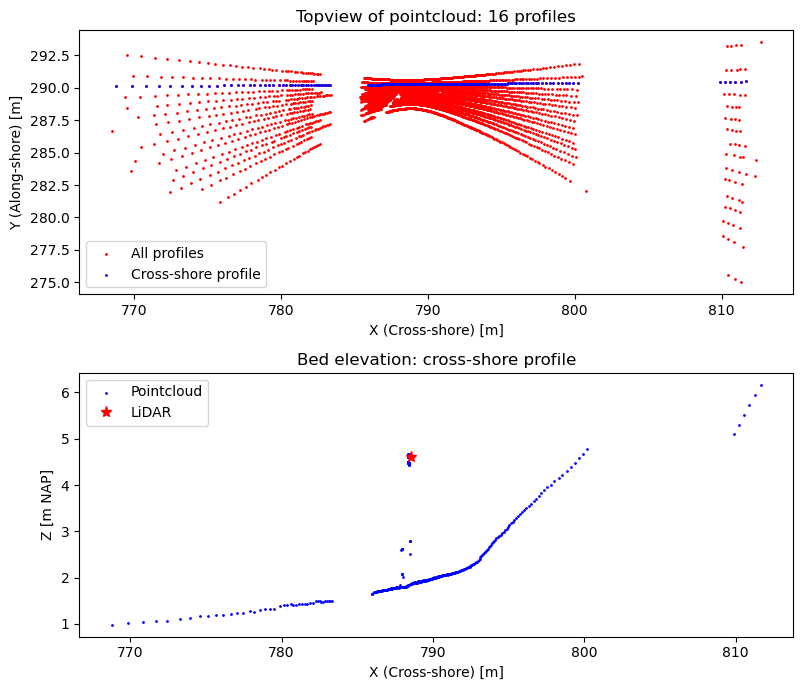

In [38]:
# Plot profiles
x_plot = np.squeeze(x[:,:,:,0])   # dims: echos x profiles x obs x timesteps.  So select first timestep
x_plot2 = np.squeeze(x[:,2,:,0])  # additionally select profile 2 (starting count at 0), i.e. cross-shore profile
y_plot = np.squeeze(y[:,:,:,0])
y_plot2 = np.squeeze(y[:,2,:,0])
z_plot = np.squeeze(z[:,2,:,0])

# plot x vs y and x vs z in two subplots. 
fig, axs = plt.subplots(2, 1, figsize=(8, 7))
axs[0].scatter(x_plot, y_plot, c='r', s=1, label='All profiles')
axs[0].scatter(x_plot2, y_plot2, c='b', s=1, label='Cross-shore profile')
axs[0].legend()

axs[0].set_xlabel('X (Cross-shore) [m]')
axs[0].set_ylabel('Y (Along-shore) [m]')
axs[0].set_title('Topview of pointcloud: 16 profiles')

axs[1].scatter(x_plot2, z_plot, c='b', s=1, label='Pointcloud')
axs[1].plot(ds.x_i_local, ds.z_i, 'r*', markersize=8, label='LiDAR')  # plot lidar position
axs[1].set_xlabel('X (Cross-shore) [m]')
axs[1].set_ylabel('Z [m NAP]')
axs[1].set_title('Bed elevation: cross-shore profile') # NB: no filtering applied. So points can be lidar frame, bed, waves, rain, ...
axs[1].legend()

plt.tight_layout()
plt.show()

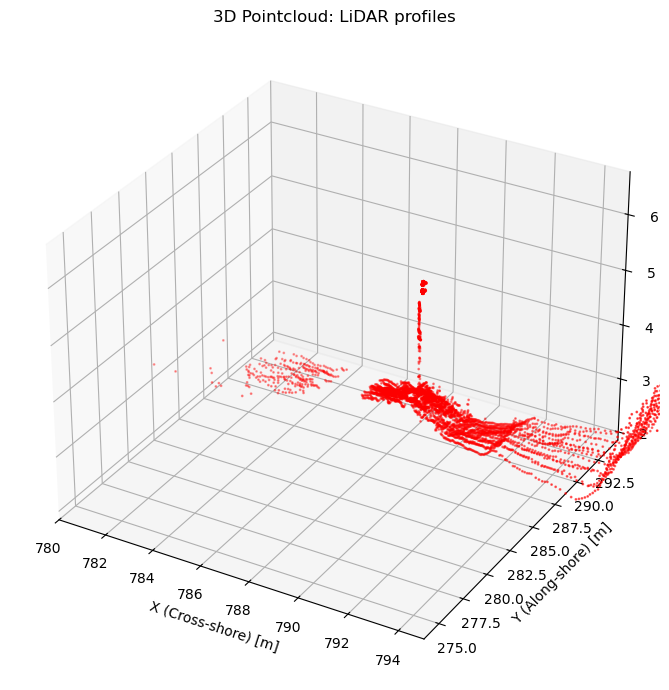

In [ ]:
# Plot all profiles, in 3D
# defome data
x_plot = np.squeeze(x[:,:,:,1])   # dims: echos x profiles x obs x timesteps.  So select second timestep
y_plot = np.squeeze(y[:,:,:,1])   # NB: the second timestep is during storm conditions, high tide. The beach is submerged, so 1) the min elevation is higher (water 
z_plot = np.squeeze(z[:,:,:,1])   # surface instead of bed). 2) Some waves are visible. 3) One of the profiles sees the lidar frame, hence the vertical pole

# plot x,y,z plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_plot, y_plot, z_plot, c='r', s=1, label='All profiles')

ax.set_xlabel('X (Cross-shore) [m]')
ax.set_ylabel('Y (Along-shore) [m]')
ax.set_zlabel('Z [m NAP]')
ax.set_title('3D Pointcloud: LiDAR profiles')
ax.set_xlim([780, 795])

plt.tight_layout()
plt.show()

In [ ]:
# Load file with detailed data (4 hz), transform coordinates

# Define file, check file contents
nc_in = r"O:\HybridDune experiment\data lidar netcdf\storm1_lidar1_polar - new.nc"

t_start = pd.Timestamp('2024-12-19 18:00')
t_end = pd.Timestamp('2024-12-19 18:10')
ds = xr.open_dataset(nc_in).sel(t=slice(t_start, t_end), profile_number=2)                                              # select specific time range

# Extract variables from dataset -----------------------------------------------------------------------
profile_angle      = ds.profile_angle
beam_angle         = ds.beam_angle
r                  = ds.radius_lidar # Dimensions if full netcdf is loaded in dataset: 3 echos x 16 profiles x 720 obs x T timesteps
#I                  = ds.intensity #uncommend when used
rotation_matrix    = ds.rotation_matrix_lidar_to_RD.values  # shape: (3, 3)
translation_matrix = np.array([ds.x_i_RD.values, ds.y_i_RD.values, ds.z_i.values])  # shape: (3,)

# NB: Along the echos axis, points are sorted by distance. If there are multiple echos, the first value is closest to the lidar, the last non-NaN value is the farthest away. 
# When interested in .e.g. bed levels: to get a single r and I value per direction, it makes sense to take the furthest point (most likely to be bed instead of water). 
# The code below does this for radius r and intensity I. 

# # Find last non-NaN along the first axis (echos)
r = r.isel(echos=slice(None, None, -1))  # flip along 'echos'
#I = I.isel(echos=slice(None, None, -1))  # flip along 'echos'

mask = ~np.isnan(r)
idx = mask.argmax(dim='echos')

r = r.isel(echos=idx)
#I = I.isel(echos=idx)

# Convert polar coordinates to cartesian coordinates, in local lidar coord system -----------------------------------------------------------------------
[x_lidar,y_lidar,z_lidar] = sph2cart( deg2rad(beam_angle), deg2rad(profile_angle), r ) # convert to cartesian xyz coordinates, in m
# Axes origin at lidar. Physical direction of the axes depends on how the lidar is placed on the beach. Transformed to RD coordinates below

# Convert to RD system -----------------------------------------------------------------------
# Stack lidar coordinates into shape (..., 3) for matrix multiplication
xyz_lidar = np.stack([x_lidar, y_lidar, z_lidar], axis=-1)  # stack in next dimension. if r is 4D, then xyz_lidar is 5D, with last dimension size 3

# Apply rotation (matrix multiply last axis) and translation
xyz_RD = np.matmul(xyz_lidar, rotation_matrix) + translation_matrix  

# Transform to x,y coordinates in local coordinate system (alongshore, cross shore) ------------------------------
theta = np.deg2rad(36.0) # local grid is rotated 36 degrees clockwise wrt RD system
rotation_matrix_RDtoLocal = np.array([ [np.cos(theta), np.sin(theta), 0],[-np.sin(theta), np.cos(theta), 0], [0, 0, 1] ])

# Subtract zero-point of local grid, then rotate 36 degrees
xyz_local = xyz_RD - np.array([71683.584, 452356.055, 0])  # shape: (3,)
xyz_local = np.matmul(xyz_local, rotation_matrix_RDtoLocal)  # shape: (16, 720, 10, 3)

# Separate x,y,z components: take the 1st/2nd/3rd slice of last dimension ----------------------------------------------------------------
x = xyz_local[..., 0]  #  dims: echos x profiles x obs x timesteps
y = xyz_local[..., 1]  
z = xyz_local[..., 2]   


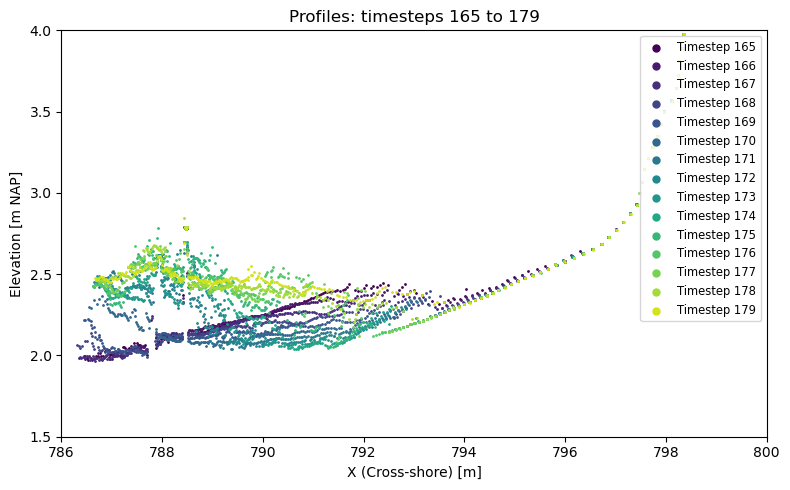

In [ ]:
# Plot x, z as scatter. Plot multiple timesteps. Let marker color indicate time
fig = plt.figure(figsize=(8, 5))

i_start = 165       # first timestep to plot                this selection gives some wave runup on the dune to
i_end = i_start+15  # last timestep to plot (exclusive)     15 steps of 0.25s, is 3.75s
i_step = 1          # step size

for t in range(i_start, min(i_end, x.shape[1]), i_step):
    plt.scatter(x[:, t], z[:, t], s=1, c=[plt.cm.viridis((t-i_start)/(i_end-i_start))], label=f'Timestep {t}')

plt.xlim([786, 800])
plt.ylim([1.5, 4])
plt.xlabel('X (Cross-shore) [m]')
plt.ylabel('Elevation [m NAP]')
plt.title(f'Profiles: timesteps {i_start} to {i_end-1}')
plt.legend(markerscale=5, fontsize='small', loc='upper right')
plt.tight_layout()
plt.show()